In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

class FashionMNISTDataset(Dataset):
    def __init__(self, train=True):
        self.data = torchvision.datasets.FashionMNIST(
            root='./data',
            train=train,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),  # Convert to tensor 
                transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1,1]
            ])
        )
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image, label = self.data[idx]
        image = image.view(-1)
        return image, label

train_dataset = FashionMNISTDataset(train=True)
test_dataset = FashionMNISTDataset(train=False)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class VAE(torch.nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=2):
        super(VAE, self).__init__()
        
        
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU()
        )
        
        # Latent space layers
        self.fc_mu = torch.nn.Linear(hidden_dim, latent_dim)
        self.fc_var = torch.nn.Linear(hidden_dim, latent_dim)
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, input_dim),
            torch.nn.Tanh()  
        )
        
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h) # mean
        log_var = self.fc_var(h)# variance
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        # Reparameterization trick
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        z = mu + eps * std
        return z
    
    def decode(self, z):
        # Decode latent vector into reconstruction
        return self.decoder(z)
    
    def forward(self, x):
        # Full forward pass
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decode(z)
        return reconstruction, mu, log_var

model = VAE()

In [ ]:
def loss_function(recon_x, x, mu, log_var):
    # Binary Cross Entropy
    BCE = torch.nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return BCE + KLD

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
train_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, log_var = model(data)
        
        loss = loss_function(recon_batch, data, mu, log_var)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    avg_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')


Epoch [5/50], Average Loss: 92.1117
Epoch [10/50], Average Loss: 87.8176
Epoch [15/50], Average Loss: 85.3892
Epoch [20/50], Average Loss: 84.0035
Epoch [25/50], Average Loss: 82.9327
Epoch [30/50], Average Loss: 82.0412
Epoch [35/50], Average Loss: 81.3101
Epoch [40/50], Average Loss: 81.0220
Epoch [45/50], Average Loss: 80.9378
Epoch [50/50], Average Loss: 80.6672


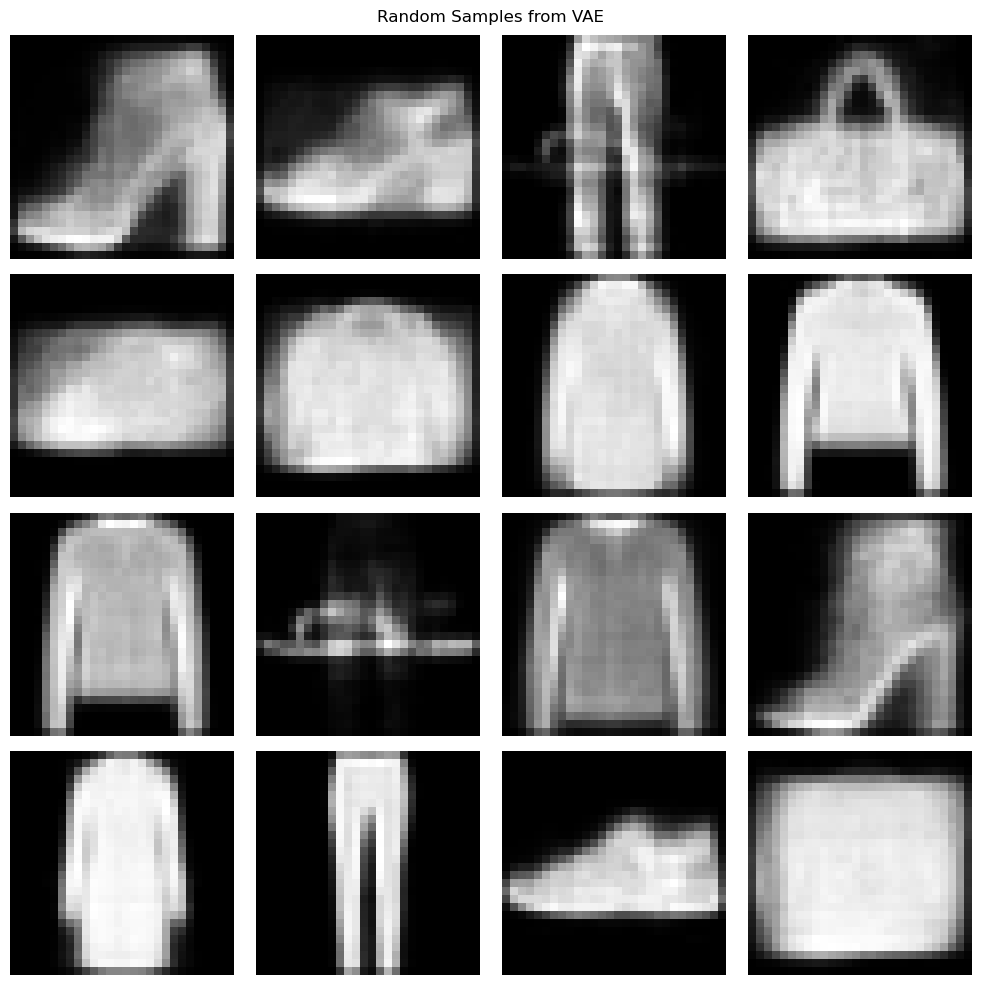

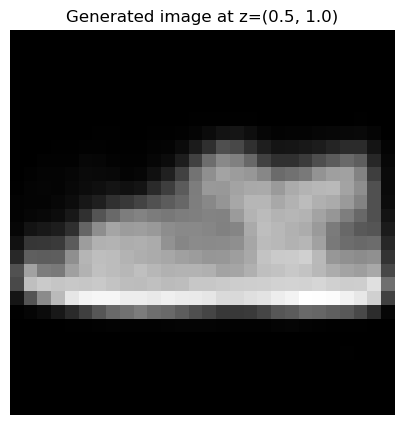

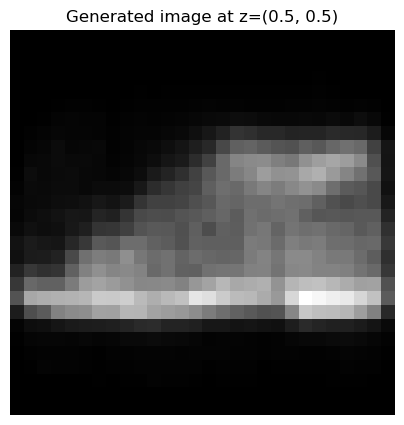

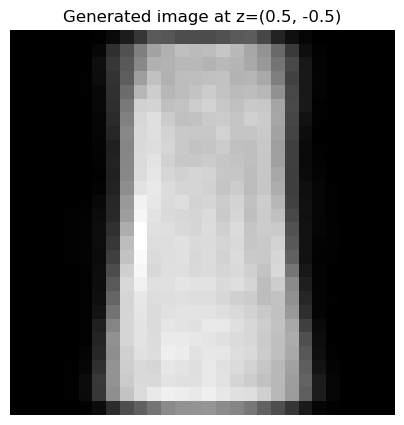

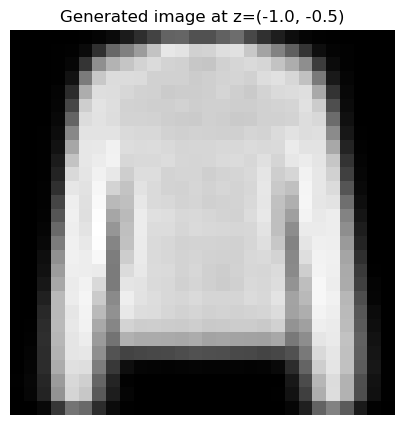

In [10]:
model.eval()


# Generate random samples
with torch.no_grad():
    # Sample random points from normal distribution
    n_samples = 16
    z = torch.randn(n_samples, 2).to(device)#random numbers from a normal distribution 
    # Generate images
    generated = model.decode(z)
    
    # Plot random samples
    plt.figure(figsize=(10, 10))
    for i in range(n_samples):
        plt.subplot(4, 4, i + 1)
        plt.imshow(generated[i].cpu().view(28, 28), cmap='gray')
        plt.axis('off')
    plt.suptitle('Random Samples from VAE')
    plt.tight_layout()
    plt.show()

def generate_from_point(x, y):
    with torch.no_grad():
        z = torch.tensor([[x, y]], device=device)
        generated = model.decode(z)
        
        plt.figure(figsize=(5, 5))
        plt.imshow(generated[0].cpu().view(28, 28), cmap='gray')
        plt.axis('off')
        plt.title(f'Generated image at z=({x:.1f}, {y:.1f})')
        plt.show()

generate_from_point(0.5, 1.0)
generate_from_point(0.5, 0.5)
generate_from_point(0.5, -0.5)
generate_from_point(-1, -0.5)
